In [1]:
import pandas as pd
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
#read images
data=[]
for i in range(10):
    img = cv2.imread('dataset/%s.jpg' %i)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())



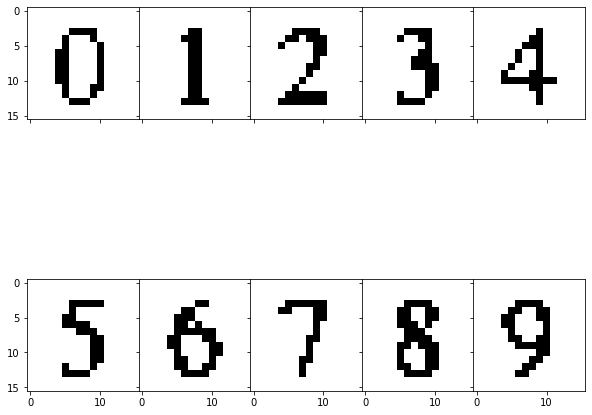

In [5]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 5, hspace=0, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
for i in range(10):
    axs[i//5, i%5].imshow(data[i].reshape(16, 16), 'gray')    

In [358]:
import torch
from torch.autograd import Variable
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))
 
#single layer perceptron
class Perceptron(torch.nn.Module):
 
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(256, 256)  # 256 in and 256 out
        self.sigmoid = torch.nn.Sigmoid() # activation function
    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
 
slp_model = Perceptron()

In [360]:
#multi layer perceptron with a fully connected hidden layer
class MLP(torch.nn.Module):
 
    def __init__(self):
        super(MLP, self).__init__()
        self.linear = torch.nn.Linear(256, 256)  # 256 in and 256 out
        self.relu = torch.nn.ReLU()
        self.hidden = torch.nn.Linear(256, 256)  # 256 in and 256 out
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        inp = self.linear(x)
        hid = self.relu(inp)
        hid = self.hidden(hid)
        out = self.sigmoid(hid)
        return out
 
mlp_model = MLP()

In [361]:
#convert numpy array to 16x16 binary image
def generate_rescaled_inputs(data):
    input_data = []
    
    for i in range(10):
        p = data[i].reshape(16, 16)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        input_data.append(p)
        
    return input_data

In [362]:
def generate_predictions(data, m):
    predicted_output = []
    
    for i in range(10):
        if m == 0:
            p = slp_model(Variable(torch.Tensor([data[i]]))).cpu().detach().numpy()
        else:
            p = mlp_model(Variable(torch.Tensor([data[i]]))).cpu().detach().numpy()
        p = p.reshape(16, 16)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        predicted_output.append(p)
    
    return predicted_output

In [363]:
def calculate_total_black_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==0)
    return count

In [364]:
def calculate_total_white_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==1)
    return count

In [365]:
def calculate_matching_black_pixels(data1, data2):
    match_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(256):
        match_ctr += 1 if(inp[i]==0 and pred[i]==0) else 0
    return match_ctr

In [366]:
def calculate_mismatching_black_pixels(data1, data2):
    mismatch_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(256):
        mismatch_ctr += 1 if(inp[i]==1 and pred[i]==0) else 0
    return mismatch_ctr

In [367]:
def compute_error_metrics(input_data, predicted_output):
    f_h = []
    f_fa = []
    
    for ix, data in enumerate(input_data):
        total_black_pixels = calculate_total_black_pixels(input_data[ix])
        total_hits = calculate_matching_black_pixels(input_data[ix], predicted_output[ix])
        fh_ratio = float(total_hits/total_black_pixels)
        # print("Fraction of hits is ", total_hits, total_black_pixels)
        f_h.append(fh_ratio)
    
    for ix, data in enumerate(input_data):
        total_white_pixels = calculate_total_white_pixels(input_data[ix])
        total_fa = calculate_mismatching_black_pixels(input_data[ix], predicted_output[ix])
        ffa_ratio = float(total_fa/total_white_pixels)
        # print("Fraction of false alarms is ", total_fa, total_white_pixels)
        f_fa.append(ffa_ratio)
    return f_h, f_fa
    

In [368]:
from random import sample
def add_noise(data, sigma):
    idx = sample(range(256), 25)
    noise = np.random.normal(0, sigma, 25)
    for i in range(25):
        data[idx[i]] += noise[i]
    return data
def normalize(data):
    mini = np.amin(data)
    maxi = np.amax(data)
    for i in range(256):
        data[i] = (data[i] - mini)/(maxi - mini)
    return data

In [369]:
noisy_data = []
for d in data:
    nd = add_noise(np.copy(d), 0.1)
    noisy_data.append(normalize(nd))


/Users/shivambang/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


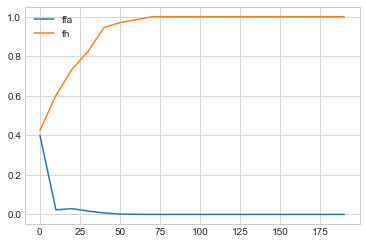

In [370]:
fh, ffa = [], []
for test in range(0, 200, 10):
    slp_model = Perceptron()
    
    criterion = torch.nn.MSELoss(size_average = False)
    optimizer = torch.optim.SGD(slp_model.parameters(), lr = 0.01)
    for epoch in range(test):
    
        # Forward pass: Compute predicted y by passing x to the model
        pred_y = slp_model(x_data)
    
        # Compute loss
        loss = criterion(pred_y, y_data)
    
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(data, 0)
    h, a = compute_error_metrics(target_values, predicted_values)
    ffa += [np.mean(a)]
    fh += [np.mean(h)]
plt.figure()
plt.plot(range(0, 200, 10), ffa, label='ffa')
plt.plot(range(0, 200, 10), fh, label='fh')
plt.legend()

In [371]:
#The ffa and fh for input data becomes stable around 100 epochs so number of epochs chosen = 100
slp_model = Perceptron()

criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(slp_model.parameters(), lr = 0.01)
for epoch in range(100):

    # Forward pass: Compute predicted y by passing x to the model
    pred_y = slp_model(x_data)

    # Compute loss
    loss = criterion(pred_y, y_data)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

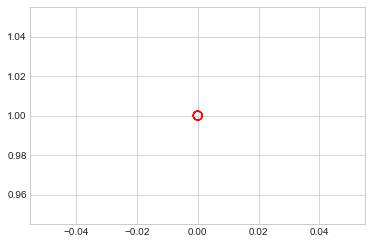

In [372]:
input_data = generate_rescaled_inputs(data)
predicted_output = generate_predictions(data, 0)
fh, ffa = compute_error_metrics(input_data, predicted_output)
plt.scatter(ffa, fh, s=80, facecolors='none', edgecolors='r')
plt.show()

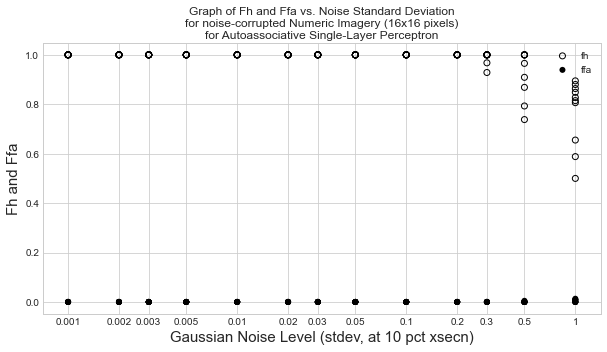

In [373]:
dfa = pd.DataFrame()
dfa.index.name = 'Image ID'
dfh = pd.DataFrame()
dfh.index.name = 'Image ID'
ffa, fh = [], []
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
for s in range(13):
    noisy_data = []
    for d in data:
        nd = add_noise(np.copy(d), sigma[s])
        noisy_data.append(normalize(nd))
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(noisy_data, 0)
    # for i in range(10):
    #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
    h, a = compute_error_metrics(target_values, predicted_values)
    ffa += a
    fh += h
    dfa['%s' %sigma[s]] = a
    dfh['%s' %sigma[s]] = h
x = [[s]*10 for s in sigma]
plt.figure(figsize=(10, 5))
plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
    "for noise-corrupted Numeric Imagery (16x16 pixels)\n"
    "for Autoassociative Single-Layer Perceptron"), loc='center', wrap=True)
plt.xlabel('Gaussian Noise Level (stdev, at 10 pct xsecn)', size=15)
plt.ylabel('Fh and Ffa', size=15)
plt.xscale('log')
plt.xticks(sigma, sigma)
plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
plt.legend()

In [374]:
print('ffa values at stdev for SLP')
dfa

ffa values at stdev for SLP


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.008658
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.008811
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.013100
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.004405
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004673,0.009346


In [375]:
print('fh values at stdev for SLP')
dfh

fh values at stdev for SLP


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.967742,1.000000,0.806452
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,0.880000
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,0.848485
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.965517,0.827586
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,0.814815
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.793103,0.655172
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.868421,0.894737
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.909091,0.863636
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.928571,0.738095,0.500000


/Users/shivambang/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


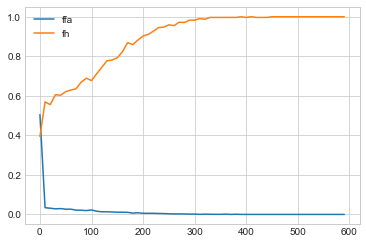

In [376]:
fh, ffa = [], []
for test in range(0, 600, 10):
    mlp_model = MLP()
    
    criterion = torch.nn.MSELoss(size_average = False)
    optimizer = torch.optim.SGD(mlp_model.parameters(), lr = 0.001)
    for epoch in range(test):
    
        # Forward pass: Compute predicted y by passing x to the model
        pred_y = mlp_model(x_data)
    
        # Compute loss
        loss = criterion(pred_y, y_data)
    
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(data, 1)
    h, a = compute_error_metrics(target_values, predicted_values)
    ffa += [np.mean(a)]
    fh += [np.mean(h)]
plt.figure()
plt.plot(range(0, 600, 10), ffa, label='ffa')
plt.plot(range(0, 600, 10), fh, label='fh')
plt.legend()

In [377]:
#The ffa and fh for input data becomes stable around 500 epochs so number of epochs chosen = 500
mlp_model = MLP()

criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(mlp_model.parameters(), lr = 0.001)
for epoch in range(500):

    # Forward pass: Compute predicted y by passing x to the model
    pred_y = mlp_model(x_data)

    # Compute loss
    loss = criterion(pred_y, y_data)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

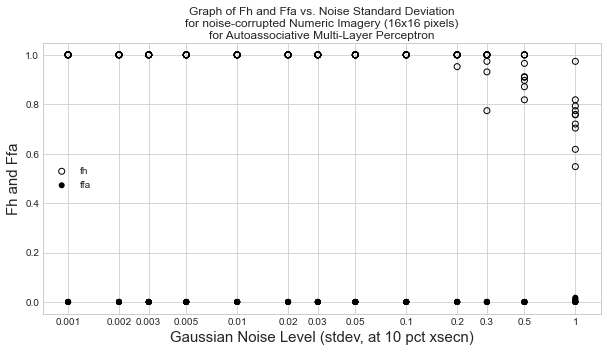

In [378]:
dfa = pd.DataFrame()
dfa.index.name = 'Image ID'
dfh = pd.DataFrame()
dfh.index.name = 'Image ID'
fh, ffa = [], []
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
for s in range(13):
    noisy_data = []
    for d in data:
        nd = add_noise(np.copy(d), sigma[s])
        noisy_data.append(normalize(nd))
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(noisy_data, 1)
    # for i in range(10):
    #     axs[i, s].imshow(predicted_values[i].reshape(16, 16))
    h, a = compute_error_metrics(target_values, predicted_values)
    ffa += a
    fh += h
    dfa['%s' %sigma[s]] = a
    dfh['%s' %sigma[s]] = h
x = [[s]*10 for s in sigma]
plt.figure(figsize=(10, 5))
plt.title(("Graph of Fh and Ffa vs. Noise Standard Deviation\n"
    "for noise-corrupted Numeric Imagery (16x16 pixels)\n"
    "for Autoassociative Multi-Layer Perceptron"), loc='center', wrap=True)
plt.xlabel('Gaussian Noise Level (stdev, at 10 pct xsecn)', size=15)
plt.ylabel('Fh and Ffa', size=15)
plt.xscale('log')
plt.xticks(sigma, sigma)
plt.scatter(x, fh, label='fh', facecolors='none', edgecolors='black')
plt.scatter(x, ffa, label='ffa', facecolors='black', edgecolors='none')
plt.legend()

In [379]:
print('ffa values at stdev for MLP')
dfa

ffa values at stdev for MLP


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008889
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017316
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013100
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004673


In [381]:
print('fh values at stdev for MLP')
dfh

fh values at stdev for MLP


,0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.1,0.2,0.3,0.5,1
Image ID,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.774194,0.870968,0.774194
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.720000
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,0.909091,0.757576
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,0.965517,0.793103
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.703704
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.931034,0.896552,0.758621
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.973684,1.000000,0.973684
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,0.818182,0.818182
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.952381,1.000000,1.000000,0.547619
